In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random, os
from tqdm import tqdm
from roomba_class import Roomba


# ### Setup Environment

def seed_everything(seed: int):
    """Seed everything for reproducibility."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def is_obstacle(position):
    """Check if the position is outside the grid boundaries (acting as obstacles)."""
    x, y = position
    return x < 0 or x >= GRID_WIDTH or y < 0 or y >= GRID_HEIGHT

def setup_environment(seed=112):
    """Setup function for grid and direction definitions."""
    global GRID_WIDTH, GRID_HEIGHT, HEADINGS, MOVEMENTS
    GRID_WIDTH = 10
    GRID_HEIGHT = 10
    HEADINGS = ['N', 'E', 'S', 'W']
    MOVEMENTS = {
        'N': (0, -1),
        'E': (1, 0),
        'S': (0, 1),
        'W': (-1, 0),
    }
    print("Environment setup complete with a grid of size {}x{}.".format(GRID_WIDTH, GRID_HEIGHT))
    seed_everything(seed)
    return GRID_WIDTH, GRID_HEIGHT, HEADINGS, MOVEMENTS


# ### Sensor Movements

def simulate_roomba(T, movement_policy,sigma):
    """
    Simulate the movement of a Roomba robot for T time steps and generate noisy observations.

    Parameters:
    - T (int): The number of time steps for which to simulate the Roomba's movement.
    - movement_policy (str): The movement policy dictating how the Roomba moves.
                             Options may include 'straight_until_obstacle' or 'random_walk'.
    - sigma (float): The standard deviation of the Gaussian noise added to the true position 
                     to generate noisy observations.

    Returns:
    - tuple: A tuple containing three elements:
        1. true_positions (list of tuples): A list of the true positions of the Roomba 
                                            at each time step as (x, y) coordinates.
        2. headings (list): A list of headings of the Roomba at each time step.
        3. observations (list of tuples): A list of observed positions with added Gaussian noise,
                                          each as (obs_x, obs_y).
    """
    # Start at the center
    start_pos = (GRID_WIDTH // 2, GRID_HEIGHT // 2)
    start_heading = random.choice(HEADINGS)
    roomba = Roomba(MOVEMENTS, HEADINGS,is_obstacle,start_pos, start_heading, movement_policy)

    true_positions = []
    observations = []
    headings = []

    print(f"Simulating Roomba movement for policy: {movement_policy}")
    for _ in tqdm(range(T), desc="Simulating Movement"):
        position = roomba.move()
        heading = roomba.heading
        true_positions.append(position)
        headings.append(heading)

        # Generate noisy observation
        noise = np.random.normal(0, sigma, 2)
        observed_position = (position[0] + noise[0], position[1] + noise[1])
        observations.append(observed_position)

    return true_positions, headings, observations


# ### Implement Functions
from math import log, pi, exp, inf
def emission_probability(state, observation, sigma):
    """
    Calculate the emission probability in log form for a given state and observation using a Gaussian distribution.
    """
    position, _ = state  # Only need position for emission probability
    # Calculate squared Euclidean distance between state position and observation
    squared_distance = (position[0] - observation[0])**2 + (position[1] - observation[1])**2
    
    # Using log of Gaussian probability density
    # log(P(observation|state)) = -distance²/(2σ²) - log(2πσ²)/2
    log_prob = (-squared_distance / (2 * sigma**2)) - np.log(2 * np.pi * sigma**2) / 2
    return log_prob

def transition_probability(prev_state, curr_state, movement_policy):
    """
    Calculate the transition probability in log form between two states based on a given movement policy.
    """
    prev_pos, prev_heading = prev_state
    curr_pos, curr_heading = curr_state
    
    # Get expected next position based on previous heading
    dx, dy = MOVEMENTS[prev_heading]
    expected_pos = (prev_pos[0] + dx, prev_pos[1] + dy)
    
    if movement_policy == 'straight_until_obstacle':
        # If no obstacle ahead, must continue straight
        if not is_obstacle(expected_pos):
            if curr_pos == expected_pos and curr_heading == prev_heading:
                return 0.0  # log(1)
            return float('-inf')  # log(0)
        
        # At obstacle, can only change direction while staying in place
        if prev_pos == curr_pos:
            # Can change to any heading except current one
            if curr_heading != prev_heading:
                return np.log(1.0/len(HEADINGS))
            return float('-inf')
        
        # Check if new position matches new heading
        dx, dy = MOVEMENTS[curr_heading]
        new_expected_pos = (prev_pos[0] + dx, prev_pos[1] + dy)
        if curr_pos == new_expected_pos:
            return np.log(1.0/len(HEADINGS))
        
        return float('-inf')
    
    elif movement_policy == 'random_walk':
        # For random walk, can move in any direction with equal probability
        dx, dy = MOVEMENTS[curr_heading]
        new_expected_pos = (prev_pos[0] + dx, prev_pos[1] + dy)
        
        # Can move in direction of heading if not blocked
        if curr_pos == new_expected_pos and not is_obstacle(curr_pos):
            return np.log(1.0/len(HEADINGS))
        # Can stay in place if blocked
        elif prev_pos == curr_pos and is_obstacle(new_expected_pos):
            return np.log(1.0/len(HEADINGS))
        
        return float('-inf')
    
    return float('-inf')  # Invalid policy

def viterbi(observations, start_state, movement_policy, states, sigma):
    """
    Perform the Viterbi algorithm to find the most likely sequence of states.
    """
    T = len(observations)  # Number of time steps
    N = len(states)       # Number of possible states
    
    # Initialize matrices
    viterbi_probs = np.full((N, T), float('-inf'))
    backpointers = np.zeros((N, T), dtype=int)
    
    # Initialize first timestep
    for i, state in enumerate(states):
        if state == start_state:
            viterbi_probs[i, 0] = emission_probability(state, observations[0], sigma)
    
    # Forward pass
    for t in range(1, T):
        for curr_idx, curr_state in enumerate(states):
            max_prob = float('-inf')
            max_idx = 0
            
            # Check all possible previous states
            for prev_idx, prev_state in enumerate(states):
                if viterbi_probs[prev_idx, t-1] == float('-inf'):
                    continue
                
                # Calculate transition and emission probabilities
                trans_prob = transition_probability(prev_state, curr_state, movement_policy)
                if trans_prob == float('-inf'):
                    continue
                    
                emit_prob = emission_probability(curr_state, observations[t], sigma)
                prob = viterbi_probs[prev_idx, t-1] + trans_prob + emit_prob
                
                # Update if better path found
                if prob > max_prob:
                    max_prob = prob
                    max_idx = prev_idx
            
            viterbi_probs[curr_idx, t] = max_prob
            backpointers[curr_idx, t] = max_idx
    
    # Backward pass to reconstruct path
    path = []
    curr_state_idx = int(np.argmax(viterbi_probs[:, -1]))
    
    # Trace back
    for t in range(T-1, -1, -1):
        path.append(states[curr_state_idx])
        curr_state_idx = backpointers[curr_state_idx, t]
    
    # Return reversed path to get chronological order
    return list(reversed(path))

if __name__ == "__main__":
    # 1. Set up the environment
    seed = 111
    setup_environment(seed)
    sigma = 1.0
    T = 50
    
    # Initialize policies and results
    policies = ['random_walk', 'straight_until_obstacle']
    results = {}
    
    # 2. Simulate Roomba movement for each policy
    for policy in policies:
        true_positions, headings, observations = simulate_roomba(T, policy, sigma)
        results[policy] = {
            'true_positions': true_positions,
            'headings': headings,
            'observations': observations
        }
    
    # 3. Generate all possible states
    states = []
    for x in range(GRID_WIDTH):
        for y in range(GRID_HEIGHT):
            for heading in HEADINGS:
                states.append(((x, y), heading))
    
    # 4. Process each policy
    for policy in policies:
        true_positions, estimated_path = getestimatedPath(policy, results, states, sigma)
        evaluate_viterbi(estimated_path, true_positions, T, policy)
        plot_results(true_positions, results[policy]['observations'], estimated_path, policy)




# ### Evaluation (DO NOT CHANGE THIS)
def getestimatedPath(policy, results, states, sigma):
    """
    Estimate the path of the Roomba using the Viterbi algorithm for a specified policy.

    Parameters:
    - policy (str): The movement policy used during simulation, such as 'random_walk' or 'straight_until_obstacle'.
    - results (dict): A dictionary containing simulation results for different policies. Each policy's data includes:
                      - 'true_positions': List of true positions of the Roomba at each time step.
                      - 'headings': List of headings of the Roomba at each time step.
                      - 'observations': List of noisy observations at each time step.
    - states (list of tuples): A list of all possible states (position, heading) for the Hidden Markov Model.
    - sigma (float): The standard deviation of the Gaussian noise used in the emission probability.

    Returns:
    - tuple: A tuple containing:
        1. true_positions (list of tuples): The list of true positions from the simulation.
        2. estimated_path (list of tuples): The most likely sequence of states estimated by the Viterbi algorithm.
    """
    print(f"\nProcessing policy: {policy}")
    data = results[policy]
    observations = data['observations']
    start_state = (data['true_positions'][0], data['headings'][0])
    estimated_path = viterbi(observations, start_state, policy, states, sigma)
    return data['true_positions'], estimated_path


def evaluate_viterbi(estimated_path, true_positions, T,policy):
    """
    Evaluate the accuracy of the Viterbi algorithm's estimated path compared to the true path.
    """
    correct = 0
    for true_pos, est_state in zip(true_positions, estimated_path):
        if true_pos == est_state[0]:
            correct += 1
    accuracy = correct / T * 100
    # data['accuracy'] = accuracy
    print(f"Tracking accuracy for {policy.replace('_', ' ')} policy: {accuracy:.2f}%")


def plot_results(true_positions, observations, estimated_path, policy):
    """
    Plot the true and estimated paths of the Roomba along with the noisy observations.
    The function plots and saves the graphs of the true and estimated paths.
    """
    # Extract coordinates
    true_x = [pos[0] for pos in true_positions]
    true_y = [pos[1] for pos in true_positions]
    obs_x = [obs[0] for obs in observations]
    obs_y = [obs[1] for obs in observations]
    est_x = [state[0][0] for state in estimated_path]
    est_y = [state[0][1] for state in estimated_path]

    # Identify start and end positions
    start_true = true_positions[0]
    end_true = true_positions[-1]
    start_est = estimated_path[0][0]
    end_est = estimated_path[-1][0]

    # Plotting
    plt.figure(figsize=(10, 10))

    # True Path Plot
    plt.subplot(2, 1, 1)
    plt.plot(true_x, true_y, 'g-', label='True Path', linewidth=2)
    plt.scatter(obs_x, obs_y, c='r', s=10, label='Observations')

    # Mark start and end positions on the true path
    plt.scatter(*start_true, c='b', marker='o', s=100, label='True Start', edgecolors='black')
    plt.scatter(*end_true, c='purple', marker='X', s=100, label='True End', edgecolors='black')

    plt.title(f'Roomba Path Tracking ({policy.replace("_", " ").title()} Policy) - True Path')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.grid(True)

    # Estimated Path Plot
    plt.subplot(2, 1, 2)
    plt.plot(est_x, est_y, 'b--', label='Estimated Path', linewidth=2)
    plt.scatter(obs_x, obs_y, c='r', s=10, label='Observations')

    # Mark start and end positions on the estimated path
    plt.scatter(*start_est, c='b', marker='o', s=100, label='Estimated Start', edgecolors='black')
    plt.scatter(*end_est, c='purple', marker='X', s=100, label='Estimated End', edgecolors='black')

    plt.title(f'Roomba Path Tracking ({policy.replace("_", " ").title()} Policy) - Estimated Path')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.grid(True)
    
    fname = f"{policy.replace('_', ' ')}_Policy_Roomba_Path_Tracking.png"
    plt.savefig(fname)



if __name__ == "__main__":
    # 1. Set up the environment, including grid size, headings, and movements.
    seed = 111
    setup_environment(seed)
    sigma = 1.0  # Observation noise standard deviation
    T = 50       # Number of time steps

    # Simulate for both movement policies
    policies = ['random_walk', 'straight_until_obstacle']
    results = {}

    # 2. Loop through each movement policy and simulate the Roomba's movement:
    #    - Generate true positions, headings, and noisy observations.
    #    - Store the results in the dictionary.
    for policy in policies:
        true_positions, headings, observations = simulate_roomba(T, policy,sigma)
        results[policy] = {
            'true_positions': true_positions,
            'headings': headings,
            'observations': observations
        }

    # 3. Define the HMM components
    #   - A list (states) containing all possible states of the Roomba, where each state is represented as a tuple ((x, y), h)
    #   - x, y: The position on the grid.
    #   - h: The heading or direction (e.g., 'N', 'E', 'S', 'W').
    states = []
    ###### YOUR CODE HERE ######

    # Generate state space
    for x in range(GRID_WIDTH):
        for y in range(GRID_HEIGHT):
            for heading in HEADINGS:
                states.append(((x, y), heading))
    
    # 4. Loop through each policy to estimate the Roomba's path using the Viterbi algorithm:
    #    - Retrieve the true positions and estimated path.
    #    - Evaluate the accuracy of the Viterbi algorithm.
    #    - Plot the true and estimated paths along with the observations.
    for policy in policies:
        true_positions, estimated_path = getestimatedPath(policy,results,states,sigma)
        evaluate_viterbi(estimated_path, true_positions, T,policy)
        plot_results(true_positions, observations, estimated_path, policy)

Environment setup complete with a grid of size 10x10.
Simulating Roomba movement for policy: random_walk


Simulating Movement: 100%|██████████| 50/50 [00:00<00:00, 26452.47it/s]


Simulating Roomba movement for policy: straight_until_obstacle


Simulating Movement: 100%|██████████| 50/50 [00:00<00:00, 142857.77it/s]


NameError: name 'getestimatedPath' is not defined


Processing seed: 111
Environment setup complete with a grid of size 10x10.
Simulating Roomba movement for policy: random_walk


Simulating Movement: 100%|██████████| 50/50 [00:00<00:00, 122211.66it/s]


Simulating Roomba movement for policy: straight_until_obstacle


Simulating Movement: 100%|██████████| 50/50 [00:00<00:00, 56741.13it/s]


Processing policy: random_walk


Tracking accuracy for random walk policy: 42.00%

Processing policy: straight_until_obstacle
Tracking accuracy for straight until obstacle policy: 100.00%

Processing seed: 42
Environment setup complete with a grid of size 10x10.
Simulating Roomba movement for policy: random_walk


Simulating Movement: 100%|██████████| 50/50 [00:00<00:00, 83752.08it/s]


Simulating Roomba movement for policy: straight_until_obstacle


Simulating Movement: 100%|██████████| 50/50 [00:00<00:00, 119088.70it/s]


Processing policy: random_walk


Tracking accuracy for random walk policy: 64.00%

Processing policy: straight_until_obstacle
Tracking accuracy for straight until obstacle policy: 100.00%

Processing seed: 777
Environment setup complete with a grid of size 10x10.
Simulating Roomba movement for policy: random_walk


Simulating Movement: 100%|██████████| 50/50 [00:00<00:00, 28567.66it/s]


Simulating Roomba movement for policy: straight_until_obstacle


Simulating Movement: 100%|██████████| 50/50 [00:00<00:00, 129533.79it/s]


Processing policy: random_walk


Tracking accuracy for random walk policy: 60.00%

Processing policy: straight_until_obstacle
Tracking accuracy for straight until obstacle policy: 98.00%

Estimated paths have been saved to 'estimated_paths.csv'


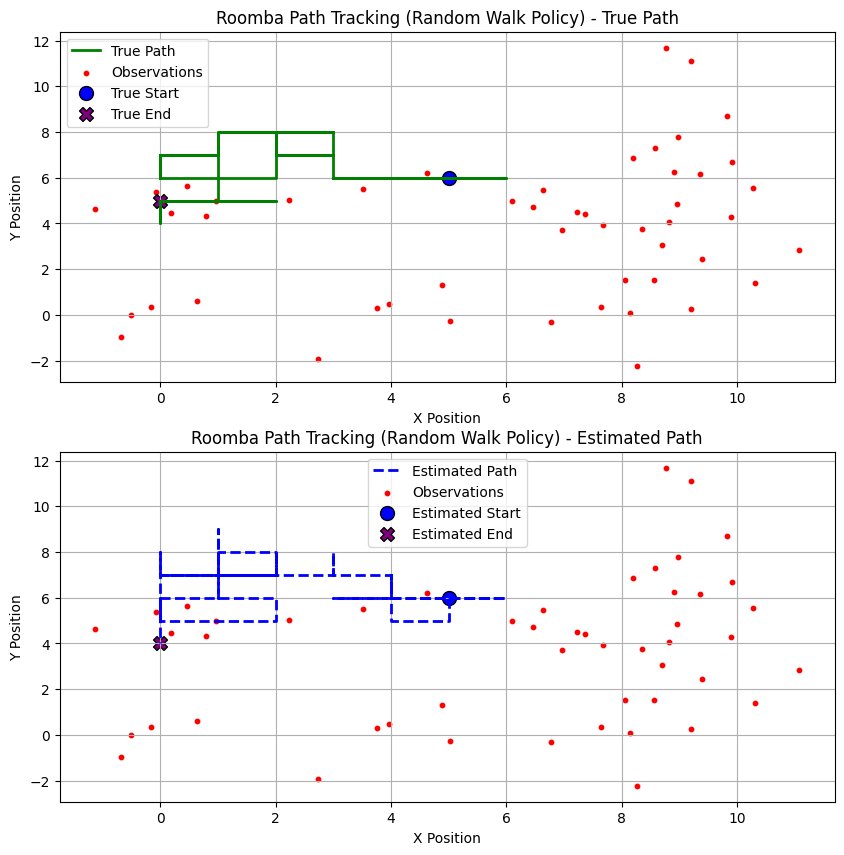

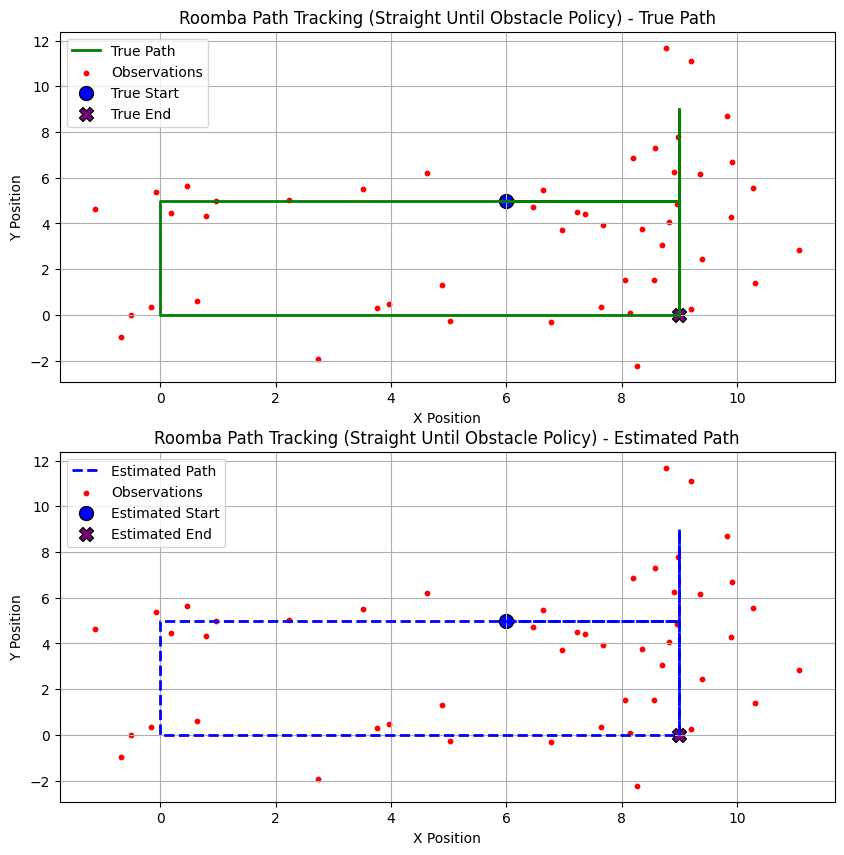

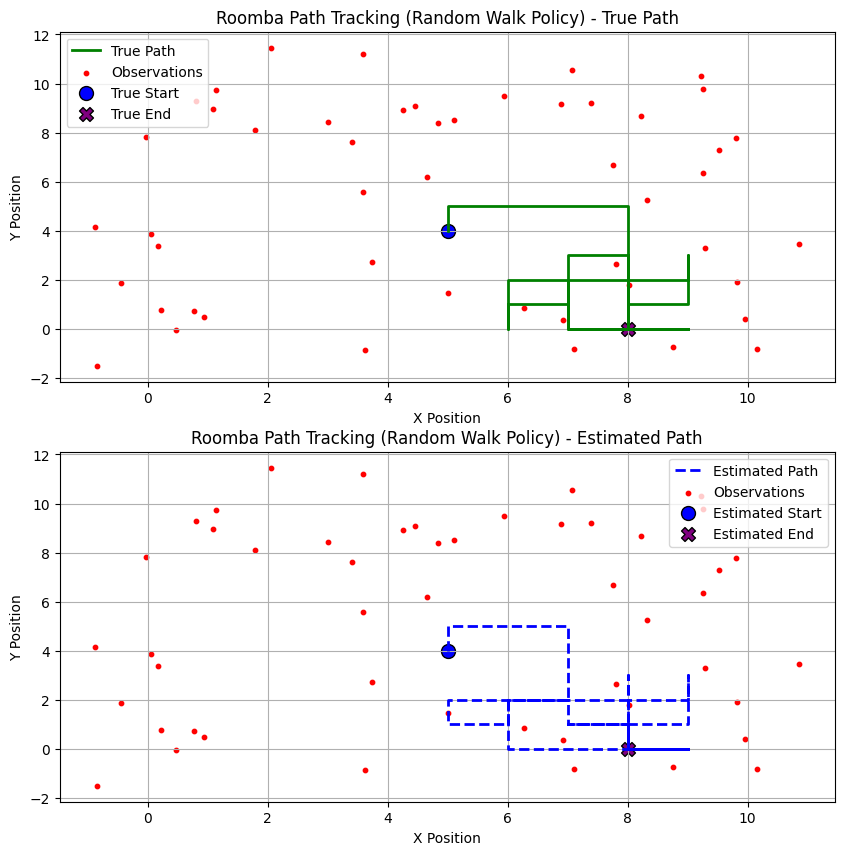

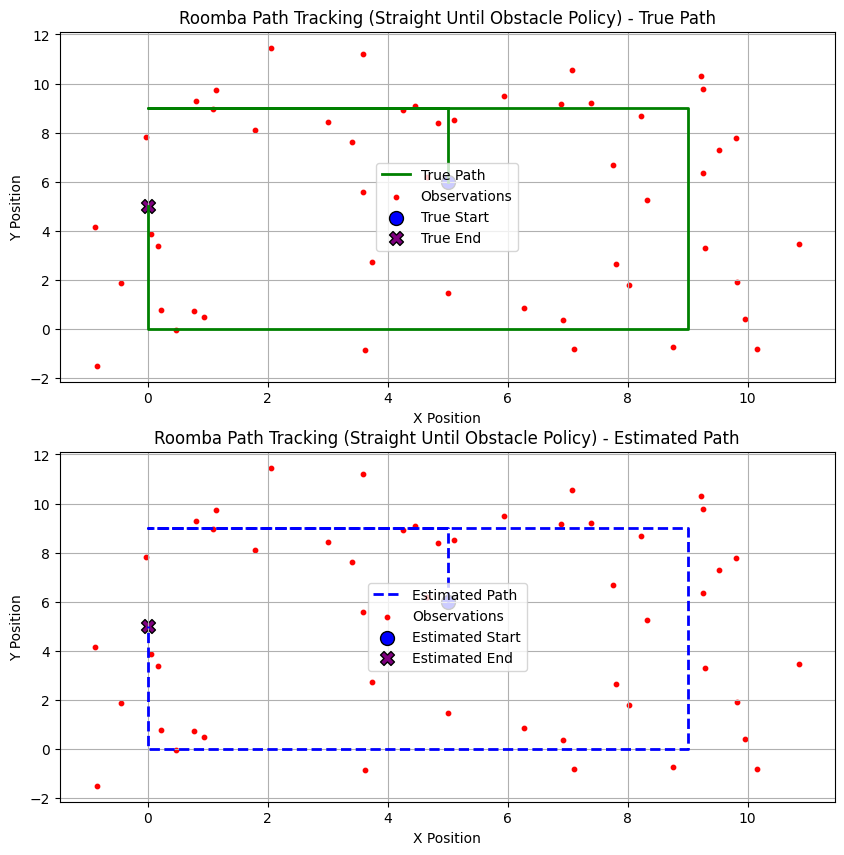

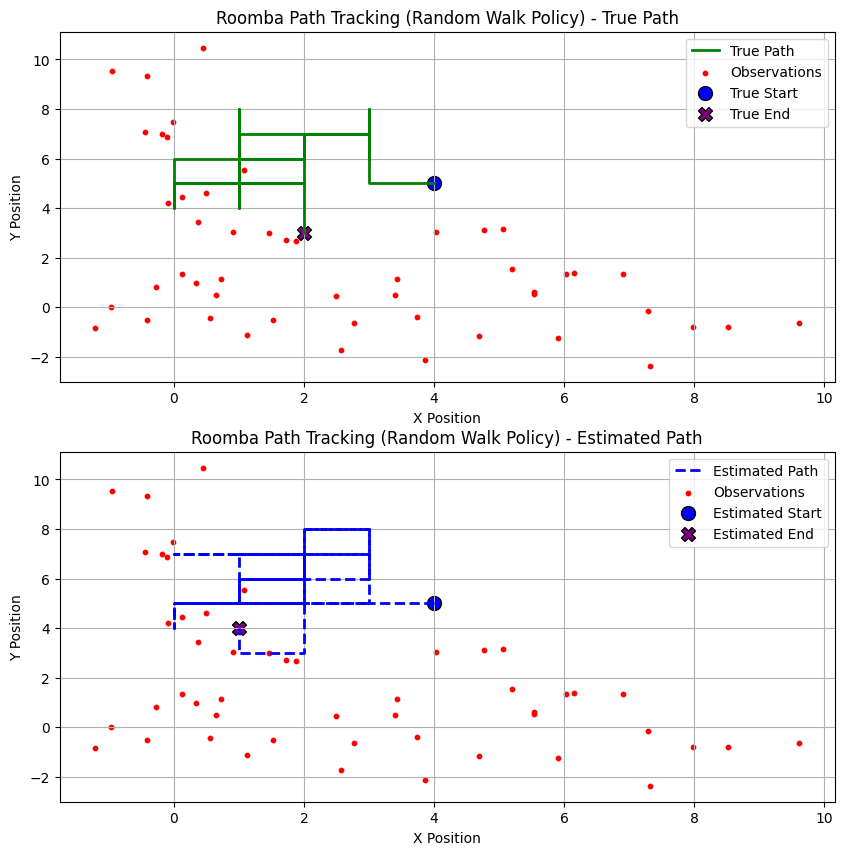

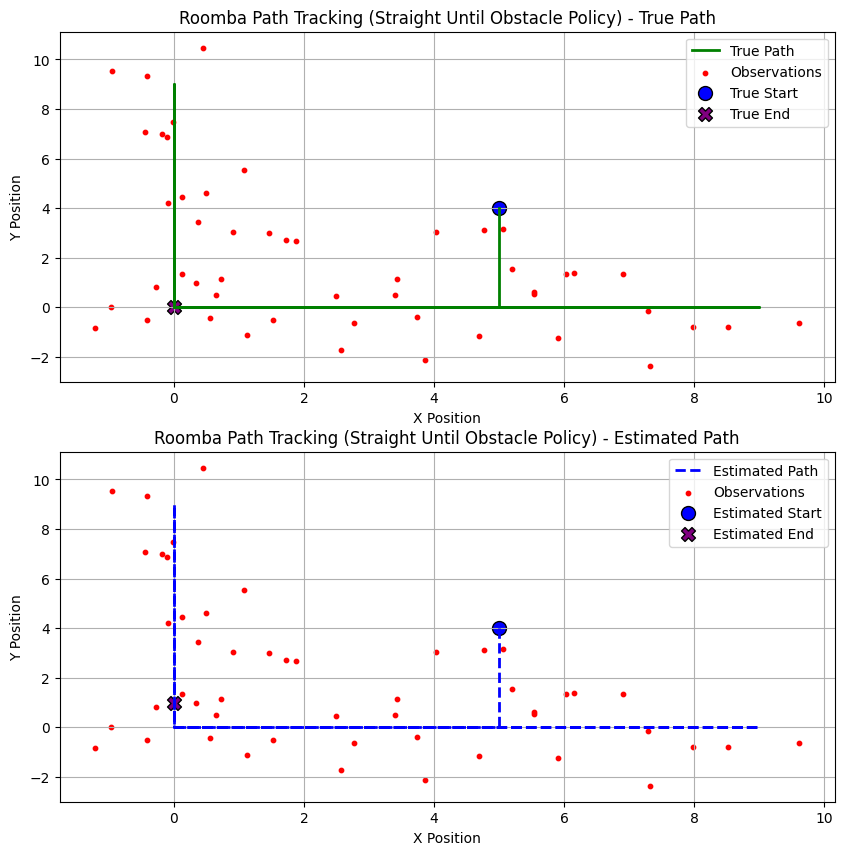

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random, os
from tqdm import tqdm
from roomba_class import Roomba


# ### Setup Environment

def seed_everything(seed: int):
    """Seed everything for reproducibility."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def is_obstacle(position):
    """Check if the position is outside the grid boundaries (acting as obstacles)."""
    x, y = position
    return x < 0 or x >= GRID_WIDTH or y < 0 or y >= GRID_HEIGHT

def setup_environment(seed=777):
    """Setup function for grid and direction definitions."""
    global GRID_WIDTH, GRID_HEIGHT, HEADINGS, MOVEMENTS
    GRID_WIDTH = 10
    GRID_HEIGHT = 10
    HEADINGS = ['N', 'E', 'S', 'W']
    MOVEMENTS = {
        'N': (0, -1),
        'E': (1, 0),
        'S': (0, 1),
        'W': (-1, 0),
    }
    print("Environment setup complete with a grid of size {}x{}.".format(GRID_WIDTH, GRID_HEIGHT))
    seed_everything(seed)
    return GRID_WIDTH, GRID_HEIGHT, HEADINGS, MOVEMENTS


# ### Sensor Movements

def simulate_roomba(T, movement_policy,sigma):
    """
    Simulate the movement of a Roomba robot for T time steps and generate noisy observations.

    Parameters:
    - T (int): The number of time steps for which to simulate the Roomba's movement.
    - movement_policy (str): The movement policy dictating how the Roomba moves.
                             Options may include 'straight_until_obstacle' or 'random_walk'.
    - sigma (float): The standard deviation of the Gaussian noise added to the true position 
                     to generate noisy observations.

    Returns:
    - tuple: A tuple containing three elements:
        1. true_positions (list of tuples): A list of the true positions of the Roomba 
                                            at each time step as (x, y) coordinates.
        2. headings (list): A list of headings of the Roomba at each time step.
        3. observations (list of tuples): A list of observed positions with added Gaussian noise,
                                          each as (obs_x, obs_y).
    """
    # Start at the center
    start_pos = (GRID_WIDTH // 2, GRID_HEIGHT // 2)
    start_heading = random.choice(HEADINGS)
    roomba = Roomba(MOVEMENTS, HEADINGS,is_obstacle,start_pos, start_heading, movement_policy)

    true_positions = []
    observations = []
    headings = []

    print(f"Simulating Roomba movement for policy: {movement_policy}")
    for _ in tqdm(range(T), desc="Simulating Movement"):
        position = roomba.move()
        heading = roomba.heading
        true_positions.append(position)
        headings.append(heading)

        # Generate noisy observation
        noise = np.random.normal(0, sigma, 2)
        observed_position = (position[0] + noise[0], position[1] + noise[1])
        observations.append(observed_position)

    return true_positions, headings, observations


# ### Implement Functions
import csv
# Add this function to save results to CSV
def save_to_csv(seed_values, policies, estimated_paths, filename='estimated_paths.csv'):
    """Save the estimated paths to a CSV file."""
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        for seed in seed_values:
            for policy in policies:
                writer.writerow([seed, policy, estimated_paths[seed][policy]])

def emission_probability(state, observation, sigma):
    """
    Calculate the emission probability in log form for a given state and observation.
    """
    position, _ = state  # We only need position for emission probability
    # Calculate squared Euclidean distance
    squared_distance = (position[0] - observation[0])**2 + (position[1] - observation[1])**2
    
    # Calculate log probability using Gaussian distribution
    # log(P(observation|state)) = -distance²/(2σ²) - log(2πσ²)/2
    log_prob = (-squared_distance / (2 * sigma**2)) - np.log(2 * np.pi * sigma**2) / 2
    return log_prob

def transition_probability(prev_state, curr_state, movement_policy):
    """
    Calculate the transition probability in log form between two states.
    """
    prev_pos, prev_heading = prev_state
    curr_pos, curr_heading = curr_state
    
    # Calculate expected position based on previous heading
    dx, dy = MOVEMENTS[prev_heading]
    expected_pos = (prev_pos[0] + dx, prev_pos[1] + dy)
    
    if movement_policy == 'straight_until_obstacle':
        if not is_obstacle(expected_pos):
            # Must continue straight if no obstacle
            if curr_pos == expected_pos and curr_heading == prev_heading:
                return 0.0  # log(1)
            return float('-inf')  # log(0)
        
        # At obstacle - can change direction
        if prev_pos == curr_pos:
            return np.log(1.0/len(HEADINGS)) if curr_heading != prev_heading else float('-inf')
        
        # Check if new position is valid for new heading
        dx, dy = MOVEMENTS[curr_heading]
        new_expected_pos = (prev_pos[0] + dx, prev_pos[1] + dy)
        if curr_pos == new_expected_pos:
            return np.log(1.0/len(HEADINGS))
        
        return float('-inf')
    
    elif movement_policy == 'random_walk':
        # Any valid move has equal probability
        dx, dy = MOVEMENTS[curr_heading]
        new_expected_pos = (prev_pos[0] + dx, prev_pos[1] + dy)
        
        if curr_pos == new_expected_pos and not is_obstacle(curr_pos):
            return np.log(1.0/len(HEADINGS))
        elif prev_pos == curr_pos and is_obstacle(new_expected_pos):
            return np.log(1.0/len(HEADINGS))
        
        return float('-inf')
    
    return float('-inf')  # Invalid policy

def viterbi(observations, start_state, movement_policy, states, sigma):
    """
    Implement Viterbi algorithm to find most likely state sequence.
    """
    T = len(observations)
    N = len(states)
    
    # Initialize matrices using numpy
    viterbi_probs = np.full((N, T), float('-inf'))
    backpointers = np.zeros((N, T), dtype=int)
    
    # Initialize first timestep
    for i, state in enumerate(states):
        if state == start_state:
            viterbi_probs[i, 0] = emission_probability(state, observations[0], sigma)
    
    # Forward pass
    for t in range(1, T):
        for curr_idx, curr_state in enumerate(states):
            max_prob = float('-inf')
            max_idx = 0
            
            for prev_idx, prev_state in enumerate(states):
                if viterbi_probs[prev_idx, t-1] == float('-inf'):
                    continue
                    
                trans_prob = transition_probability(prev_state, curr_state, movement_policy)
                if trans_prob == float('-inf'):
                    continue
                    
                emit_prob = emission_probability(curr_state, observations[t], sigma)
                prob = viterbi_probs[prev_idx, t-1] + trans_prob + emit_prob
                
                if prob > max_prob:
                    max_prob = prob
                    max_idx = prev_idx
            
            viterbi_probs[curr_idx, t] = max_prob
            backpointers[curr_idx, t] = max_idx
    
    # Backward pass
    path = []
    current_state_idx = int(np.argmax(viterbi_probs[:, -1]))
    
    # Trace back
    for t in range(T-1, -1, -1):
        path.append(states[current_state_idx])
        current_state_idx = backpointers[current_state_idx, t]
    
    # Reverse path to get chronological order
    return list(reversed(path))




# ### Evaluation (DO NOT CHANGE THIS)
def getestimatedPath(policy, results, states, sigma):
    """
    Estimate the path of the Roomba using the Viterbi algorithm for a specified policy.

    Parameters:
    - policy (str): The movement policy used during simulation, such as 'random_walk' or 'straight_until_obstacle'.
    - results (dict): A dictionary containing simulation results for different policies. Each policy's data includes:
                      - 'true_positions': List of true positions of the Roomba at each time step.
                      - 'headings': List of headings of the Roomba at each time step.
                      - 'observations': List of noisy observations at each time step.
    - states (list of tuples): A list of all possible states (position, heading) for the Hidden Markov Model.
    - sigma (float): The standard deviation of the Gaussian noise used in the emission probability.

    Returns:
    - tuple: A tuple containing:
        1. true_positions (list of tuples): The list of true positions from the simulation.
        2. estimated_path (list of tuples): The most likely sequence of states estimated by the Viterbi algorithm.
    """
    print(f"\nProcessing policy: {policy}")
    data = results[policy]
    observations = data['observations']
    start_state = (data['true_positions'][0], data['headings'][0])
    estimated_path = viterbi(observations, start_state, policy, states, sigma)
    return data['true_positions'], estimated_path


def evaluate_viterbi(estimated_path, true_positions, T,policy):
    """
    Evaluate the accuracy of the Viterbi algorithm's estimated path compared to the true path.
    """
    correct = 0
    for true_pos, est_state in zip(true_positions, estimated_path):
        if true_pos == est_state[0]:
            correct += 1
    accuracy = correct / T * 100
    # data['accuracy'] = accuracy
    print(f"Tracking accuracy for {policy.replace('_', ' ')} policy: {accuracy:.2f}%")


def plot_results(true_positions, observations, estimated_path, policy):
    """
    Plot the true and estimated paths of the Roomba along with the noisy observations.
    The function plots and saves the graphs of the true and estimated paths.
    """
    # Extract coordinates
    true_x = [pos[0] for pos in true_positions]
    true_y = [pos[1] for pos in true_positions]
    obs_x = [obs[0] for obs in observations]
    obs_y = [obs[1] for obs in observations]
    est_x = [state[0][0] for state in estimated_path]
    est_y = [state[0][1] for state in estimated_path]

    # Identify start and end positions
    start_true = true_positions[0]
    end_true = true_positions[-1]
    start_est = estimated_path[0][0]
    end_est = estimated_path[-1][0]

    # Plotting
    plt.figure(figsize=(10, 10))

    # True Path Plot
    plt.subplot(2, 1, 1)
    plt.plot(true_x, true_y, 'g-', label='True Path', linewidth=2)
    plt.scatter(obs_x, obs_y, c='r', s=10, label='Observations')

    # Mark start and end positions on the true path
    plt.scatter(*start_true, c='b', marker='o', s=100, label='True Start', edgecolors='black')
    plt.scatter(*end_true, c='purple', marker='X', s=100, label='True End', edgecolors='black')

    plt.title(f'Roomba Path Tracking ({policy.replace("_", " ").title()} Policy) - True Path')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.grid(True)

    # Estimated Path Plot
    plt.subplot(2, 1, 2)
    plt.plot(est_x, est_y, 'b--', label='Estimated Path', linewidth=2)
    plt.scatter(obs_x, obs_y, c='r', s=10, label='Observations')

    # Mark start and end positions on the estimated path
    plt.scatter(*start_est, c='b', marker='o', s=100, label='Estimated Start', edgecolors='black')
    plt.scatter(*end_est, c='purple', marker='X', s=100, label='Estimated End', edgecolors='black')

    plt.title(f'Roomba Path Tracking ({policy.replace("_", " ").title()} Policy) - Estimated Path')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.grid(True)
    
    fname = f"{policy.replace('_', ' ')}_Policy_Roomba_Path_Tracking.png"
    plt.savefig(fname)



# if __name__ == "__main__":
#     # 1. Set up the environment, including grid size, headings, and movements.
#     seed = 111
#     setup_environment(seed)
#     sigma = 1.0  # Observation noise standard deviation
#     T = 50       # Number of time steps

#     # Simulate for both movement policies
#     policies = ['random_walk', 'straight_until_obstacle']
#     results = {}

#     # 2. Loop through each movement policy and simulate the Roomba's movement:
#     #    - Generate true positions, headings, and noisy observations.
#     #    - Store the results in the dictionary.
#     for policy in policies:
#         true_positions, headings, observations = simulate_roomba(T, policy,sigma)
#         results[policy] = {
#             'true_positions': true_positions,
#             'headings': headings,
#             'observations': observations
#         }

#     # 3. Define the HMM components
#     #   - A list (states) containing all possible states of the Roomba, where each state is represented as a tuple ((x, y), h)
#     #   - x, y: The position on the grid.
#     #   - h: The heading or direction (e.g., 'N', 'E', 'S', 'W').
#     states = []
#     ###### YOUR CODE HERE ######

#     # Generate state space
#     for x in range(GRID_WIDTH):
#         for y in range(GRID_HEIGHT):
#             for heading in HEADINGS:
#                 states.append(((x, y), heading))
    
#     # 4. Loop through each policy to estimate the Roomba's path using the Viterbi algorithm:
#     #    - Retrieve the true positions and estimated path.
#     #    - Evaluate the accuracy of the Viterbi algorithm.
#     #    - Plot the true and estimated paths along with the observations.
#     for policy in policies:
#         true_positions, estimated_path = getestimatedPath(policy,results,states,sigma)
#         evaluate_viterbi(estimated_path, true_positions, T,policy)
#         plot_results(true_positions, observations, estimated_path, policy)
        
        
# In the main execution block:
if __name__ == "__main__":
    # Define seeds and policies
    seed_values = [111, 42, 777]
    policies = ['random_walk', 'straight_until_obstacle']
    all_estimated_paths = {}
    sigma = 1.0
    T = 50

    # Run simulations and collect paths
    for seed in seed_values:
        print(f"\nProcessing seed: {seed}")
        setup_environment(seed)
        all_estimated_paths[seed] = {}
        sigma = 1.0  # Observation noise standard deviation
        T = 50       # Number of time steps

        # Simulate for both movement policies
        policies = ['random_walk', 'straight_until_obstacle']
        results = {}

        # 2. Loop through each movement policy and simulate the Roomba's movement:
        #    - Generate true positions, headings, and noisy observations.
        #    - Store the results in the dictionary.
        for policy in policies:
            true_positions, headings, observations = simulate_roomba(T, policy,sigma)
            results[policy] = {
                'true_positions': true_positions,
                'headings': headings,
                'observations': observations
            }

        # 3. Define the HMM components
        #   - A list (states) containing all possible states of the Roomba, where each state is represented as a tuple ((x, y), h)
        #   - x, y: The position on the grid.
        #   - h: The heading or direction (e.g., 'N', 'E', 'S', 'W').
        states = []
        ###### YOUR CODE HERE ######

        # Generate state space
        for x in range(GRID_WIDTH):
            for y in range(GRID_HEIGHT):
                for heading in HEADINGS:
                    states.append(((x, y), heading))
        
        # 4. Loop through each policy to estimate the Roomba's path using the Viterbi algorithm:
        #    - Retrieve the true positions and estimated path.
        #    - Evaluate the accuracy of the Viterbi algorithm.
        #    - Plot the true and estimated paths along with the observations.
        for policy in policies:
            true_positions, estimated_path = getestimatedPath(policy,results,states,sigma)
            all_estimated_paths[seed][policy] = estimated_path
            evaluate_viterbi(estimated_path, true_positions, T,policy)
            plot_results(true_positions, observations, estimated_path, policy)
    
    # Save results to CSV
    save_to_csv(seed_values, policies, all_estimated_paths)
    print("\nEstimated paths have been saved to 'estimated_paths.csv'")